In [2]:
import numpy as np
import pandas as pd
from numpy import pi as pi
from scipy import interpolate
from scipy.misc import derivative
import matplotlib.pyplot as plt

In [3]:
def d(x,y):
    return -np.log(np.exp(-(((x-y)**2+(1e-20)**2)**.5))+np.exp(-(180-((x-y)**2+(1e-20)**2)**.5)))

# gaussian function and stimulus function
def gaussian(x, y, sigma): # Gaussian function centered at y
    return np.exp(-np.power(d(x,y), 2.) / (2 * np.power(sigma, 2.)))

def hfunc(x, phi, sigma_FF): # stimulus of orientation phi
    return gaussian(x, phi, sigma_FF)

# threshold quadratic transfer function
def f(k, n, Ialpha):
    return k*(np.power((np.maximum(Ialpha,0)), n))

def xfer_func(Ialpha):
    return 0.04*(np.power((np.maximum(Ialpha, 0)), 2))

def df(Ialpha):
    return 2*0.04*np.maximum(Ialpha,0)

# Independent noise

In [4]:
def two_ring_model(t0, T, dt, phi, N, tau_E, tau_I, tau_n, c_ne, c_ni, B, J_EE, J_II, J_EI, J_IE, sigma_ori, sigma_FF, k, n, c, a, b):
    # firing rate vectors for ring 1 and ring 2
    r1 = np.zeros((2*N,1))
    r2 = np.zeros((2*N,1))
    r_E1 = np.zeros((N,1))
    r_I1 = np.zeros((N,1))
    r_E2 = np.zeros((N,1))
    r_I2 = np.zeros((N,1))

    # matrices to store firing rates as row and time as column
    R_ss = np.zeros((4*N, 1))
    R_n = np.zeros((4*N, 1))

    xs = np.linspace(0, N-1, N)

    G_ori = np.fromfunction(lambda x,y: gaussian(x,y,sigma_ori), (N,N)) # Connectivity matrix 
    h = np.array([hfunc(x, phi, sigma_FF) for x in range(N)]) # has shape (180,)
    h = h[:,None] # makes shape (180,1)

    W_E1E1 = W_E2E2 = J_EE*G_ori
    W_E1I1 = W_E2I2 = J_EI*G_ori
    W_I1E1 = W_I2E2 = J_IE*G_ori
    W_I1I1 = W_I2I2 = J_II*G_ori

    W_E1E2 = b*W_E2E2 # b scales ring2 output connectivity strength wrt within ring2 connectivity strength
    W_E1I2 = b*W_E2I2
    W_I1E2 = b*W_I2E2
    W_I1I2 = b*W_I2I2

    W_E2E1 = a*W_E1E1 # a scales ring1 output connectivity strength wrt within ring1 connectivity strength
    W_E2I1 = a*W_E1I1
    W_I2E1 = a*W_I1E1
    W_I2I1 = a*W_I1I1

    W = np.block([
        [W_E1E1, W_E1I1,          W_E1E2, W_E1I2], 
        [W_I1E1, W_I1I1,          W_I1E2, W_I1I2], 
        
        
        [W_E2E1, W_E2I1,          W_E2E2, W_E2I2], 
        [W_I2E1, W_I2I1,          W_I2E2, W_I2I2]
    ])
    
    sgn = np.block([
        [np.ones((4*N,N)), -np.ones((4*N,N)), np.ones((4*N,N)), -np.ones((4*N,N))]
    ])


    h = np.block([
        [h],
        [h],
        [h],
        [h]
    ])

    r_ss = np.block([
        [r_E1],
        [r_I1], 
        [r_E2], 
        [r_I2]
    ])
    
    r_n = np.block([
        [r_E1],
        [r_I1], 
        [r_E2], 
        [r_I2]
    ])
    
    # initial inputs 
    Id = np.full((4*N,1), B) + c*h + (sgn*W)@r_ss
    In = np.full((4*N,1), B) + c*h + (sgn*W)@r_n
    
    
    # smoothed noise process 
    eta = np.zeros((4*N, 1))
    
    # vector of E/I timescales 
    tau = np.block([
        [np.full((N,1), tau_E)],
        [np.full((N,1), tau_I)],
        [np.full((N,1), tau_E)],
        [np.full((N,1), tau_I)]
    ])
    
    # vector of noise magnitudes
    c_n = np.block([
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ni)],
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ni)]
    ])
    
    M = int(T/dt)
    ts = np.arange(M+1)
    
    for m in range(M):
    # deterministic sim
        r_ss += dt*(1/tau)*(-r_ss + f(k, n, Id))
        Id = np.full((4*N,1), B) + c*h + (sgn*W)@r_ss
        R_ss = np.c_[R_ss, r_ss]
    # noise sim
        x = np.random.randn(4*N,1)
        eta += (1/tau_n) * (-eta * dt + np.sqrt(2*tau_n*dt)*x)
        r_n += dt*(1/tau)*(-r_n + f(k, n, In + c_n*eta))
        In = np.full((4*N,1), B) + c*h + (sgn*W)@r_n # note: sgn matrix incorporates minus signs for I
        R_n = np.c_[R_n, r_n]
        
    return r_ss, r_n, R_ss, R_n, W, xs, ts, c, h

In [5]:
def calculate_cov(f, N, h, c, r_ss, W, c_ne, c_ni, tau_n):
    sgn = np.block([
        [np.ones((4*N,N)), -np.ones((4*N,N)), np.ones((4*N,N)), -np.ones((4*N,N))]
    ])
    
    xs = np.arange(-20000,20000)
    #df = interpolate.InterpolatedUnivariateSpline(xs, np.diff(f(0.04, 2, xs), prepend=0))
    #L = np.diagflat(df(c*h + (sgn*W)@r_ss))
    #L = np.diagflat(derivative(f, c*h + (sgn*W)@r_ss, dx=1e-6, n=1))
    L = np.diagflat(2*.04*np.maximum(c*h + (sgn*W)@r_ss,0))
    
    LW = L@(sgn*W)
    Eye = np.eye(4*N)
    
    M = -Eye + LW
    Minv = np.linalg.inv(M)
    
    c_n = np.diagflat(np.block([
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ni)],
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ni)]
    ]))
    
    D = c_n@L
    D = np.sqrt(2*tau_n)*D

    Sigma = (Minv@D)@((Minv@D).T)
    
    return Sigma, L, D

In [26]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

In [166]:
r_ss, r_n, R_ss, R_n, W, xs, ts, c, h = two_ring_model(t0=0, 
                                             T=500, 
                                             dt=0.1, 
                                             phi=45, 
                                             N=180, 
                                             tau_E=20, 
                                             tau_I=10, 
                                             tau_n = 1, 
                                             c_ne=1, 
                                             c_ni=1, 
                                                       
                                             B = 0,
                                                       
                                             J_EE=0.044, 
                                             J_II=0.017, 
                                             J_EI=0.020, 
                                             J_IE=0.042, 
                                                       
                                             sigma_ori=32, 
                                             #sigma_FF=50, 
                                             sigma_FF = 60,
                                             k=0.04, 
                                             n=2.0, 
                                             c=20,
                                             
                                             a=.6, 
                                             b=.8)

## Theoretical calculations: $\Sigma$, $FI_E$

### $\alpha = 0.6, \beta = 0.8$ 

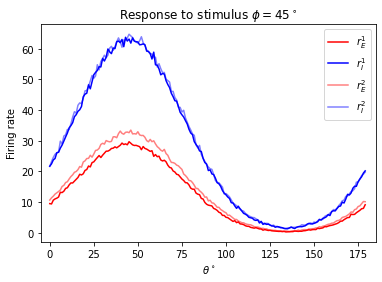

In [120]:
N = 180

plt.plot(r_n[:N], label=r'$r_E^1$', color='r', alpha=1)
plt.plot(r_n[N:2*N], label=r'$r_I^1$', color='b', alpha=1)
plt.plot(r_n[2*N:3*N], label=r'$r_E^2$', color='r', alpha=.5)
plt.plot(r_n[3*N:], label=r'$r_I^2$', color='b', alpha=.5)
plt.title(r'Response to stimulus $\phi=45^\circ$')
plt.xlim(-5,185)
plt.xlabel(r'$\theta^\circ$')
plt.ylabel('Firing rate')
plt.legend()
plt.show()

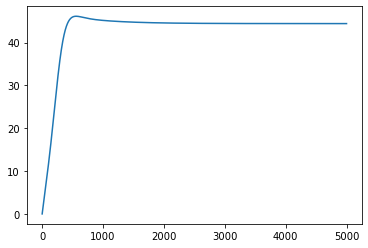

In [100]:
plt.plot(R_ss[200])
plt.show()

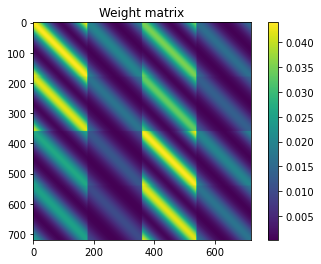

In [101]:
plt.imshow(W)
plt.colorbar()
plt.title('Weight matrix')
plt.show()

In [102]:
Sigma, L, D = calculate_cov(f=xfer_func, N=180, h=h, c=c, r_ss=r_ss, W=W, c_ne=1, c_ni=1, tau_n=1)

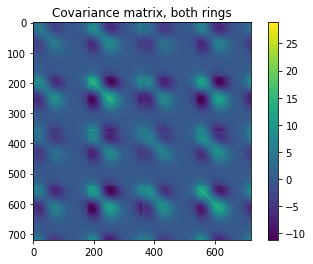

In [103]:
plt.imshow(Sigma)
plt.colorbar()
plt.title('Covariance matrix, both rings')
plt.show()

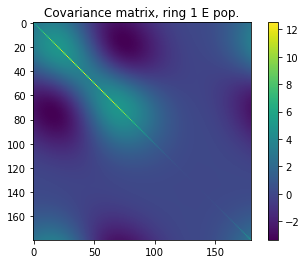

In [104]:
plt.imshow(Sigma[:180,:180])
plt.colorbar()
plt.title('Covariance matrix, ring 1 E pop.')
plt.show()

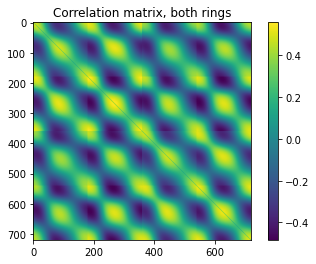

In [105]:
C = correlation_from_covariance(Sigma)

plt.imshow(C-np.diagflat(np.diag(C)))
#plt.imshow(C)
plt.title('Correlation matrix, both rings')
plt.colorbar()
plt.show()

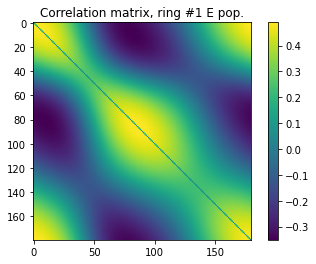

In [106]:
plt.imshow(C[:N,:N]-np.diagflat(np.diag(C[:N,:N])))
#plt.imshow(C)
plt.title('Correlation matrix, ring #1 E pop.')
plt.colorbar()
plt.show()

The next two plots fix a neuron $i(r)$ at $i(r) = 45^\circ$ and 
display $\text{Corr}(i(r), j(r))$ for all $j(r) \neq i(r)$. The argument $r$ is meant to emphasize from which ring neuron $i$ is from; so $r \in \{\text{ring}_1, \text{ring}_2\}.$

For example, the blue curve fixes neuron $i(\text{ring}_1) = 45$, and plots $\text{Corr}(i(\text{ring}_1), j(\text{ring}_1))$ for all $j(\text{ring}_1) \neq i(\text{ring}_1)$; ie, the pairwise correlations between the neuron at 45 degrees in ring 1 with all other neurons in ring 1. Likewise, the orange curve fixes a neuron $i(\text{ring}_2) = 45$, and plots $\text{Corr}(i(\text{ring}_2), j(\text{ring}_2)).$ 

The green curve fixes a neuron $i(\text{ring}_2) = 45$ and plots $\text{Corr}(i(\text{ring}_2), j(\text{ring}_1))$ for all $j(\text{ring}_1) \neq i(\text{ring}_2)$. 

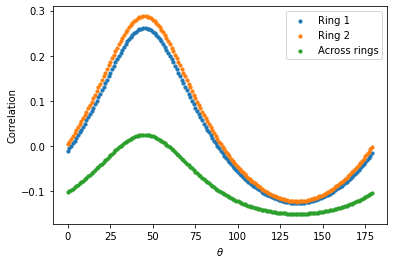

In [107]:
C1_E = C[:N, :N]
C2_E = C[2*N:3*N, 2*N:3*N]
C12_E = C[:N, 2*N:3*N]

y1 = np.delete(C1_E[45,:], [45])
y2 = np.delete(C2_E[45,:], [45])
y12 = np.delete(C12_E[45,:], [45])

xs = np.arange(180)
xs = np.delete(xs, [45])

plt.scatter(xs, y1, s=10, label='Ring 1')
plt.scatter(xs, y2, s=10, label='Ring 2')
plt.scatter(xs, y12, s=10, label='Across rings')

plt.ylabel('Correlation')
plt.xlabel(r'$\theta$')
plt.legend()

plt.show()

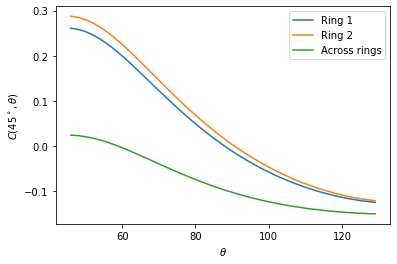

In [119]:
xs=np.arange(46,130)
plt.plot(xs, C1_E[45,46:130], label='Ring 1')
plt.plot(xs, C2_E[45,46:130], label='Ring 2')
plt.plot(xs, C12_E[45,46:130], label='Across rings')
plt.legend()
plt.ylabel(r'$C(45^\circ, \theta)$')
plt.xlabel(r'$\theta$')
plt.show()

## $FI_E$ as a function of connectivity parameter

In [47]:
betas = np.arange(0, 0.1, 0.0025)
alphas = np.arange(0, 0.1,0.0025)
betas = betas[::-1]
alphas = alphas[::-1]

In [169]:
#FI_E1 = np.zeros((len(alphas), len(betas)))
#FI_E2 = np.zeros((len(alphas), len(betas)))

FI_1lst = []
FI_2lst = []
betas = np.arange(0, .325, .025)
alphas = np.arange(0, .35, .05)

for a in alphas:
    FI_E1 = []
    FI_E2 = []
    
    print(f'alpha={a}')
    for b in betas:
        print(f'\t beta = {b}')

        r_ss, r_n, R_ss, R_n, W, xs, ts, c, h = two_ring_model(t0=0, 
                                                 T=500, 
                                                 dt=0.1, 
                                                 phi=45, 
                                                 N=180, 
                                                 tau_E=20, 
                                                 tau_I=10, 
                                                 tau_n = 1, 
                                                 c_ne=1, 
                                                 c_ni=1, 

                                                 B = 0,

                                                 J_EE=0.044, 
                                                 J_II=0.017, 
                                                 J_EI=0.020, 
                                                 J_IE=0.042, 

                                                 sigma_ori=32, 
                                                 sigma_FF=45, 

                                                 k=0.04, 
                                                 n=2.0, 
                                                 c=40,

                                                 a=a, 
                                                 b=b)

        Sigma, L, D = calculate_cov(f=xfer_func, N=180, h=h, c=c, r_ss=r_ss, W=W, c_ne=1, c_ni=1, tau_n=1)
        N = 180

        Sigma1_E = Sigma[:N, :N]
        Sigma2_E = Sigma[2*N:3*N, 2*N:3*N]

        Sigma1_E_inv = np.linalg.inv(Sigma1_E)
        Sigma2_E_inv = np.linalg.inv(Sigma2_E)

        rss_E1 = r_ss[:N]
        rss_E2 = r_ss[2*N:3*N]

        G_E1 = np.diff(rss_E1, axis=0, append=rss_E1[0][0])
        G_E2 = np.diff(rss_E2, axis=0, append=rss_E2[0][0])

        fi_E1 = ((G_E1.T)@Sigma1_E_inv@G_E1)[0][0]
        fi_E2 = ((G_E2.T)@Sigma2_E_inv@G_E2)[0][0]
        #print(f'FI_E1 = {fi_E1}')

        FI_E1.append(fi_E1)
        FI_E2.append(fi_E2)
        
    FI_1lst.append(FI_E1)
    FI_2lst.append(FI_E2)
        

alpha=0.0
	 beta = 0.0
	 beta = 0.025
	 beta = 0.05
	 beta = 0.07500000000000001
	 beta = 0.1
	 beta = 0.125
	 beta = 0.15000000000000002
	 beta = 0.17500000000000002
	 beta = 0.2
	 beta = 0.225
	 beta = 0.25
	 beta = 0.275
	 beta = 0.30000000000000004
alpha=0.05
	 beta = 0.0
	 beta = 0.025
	 beta = 0.05
	 beta = 0.07500000000000001
	 beta = 0.1
	 beta = 0.125
	 beta = 0.15000000000000002
	 beta = 0.17500000000000002
	 beta = 0.2
	 beta = 0.225
	 beta = 0.25
	 beta = 0.275
	 beta = 0.30000000000000004
alpha=0.1
	 beta = 0.0
	 beta = 0.025
	 beta = 0.05
	 beta = 0.07500000000000001
	 beta = 0.1
	 beta = 0.125
	 beta = 0.15000000000000002
	 beta = 0.17500000000000002
	 beta = 0.2
	 beta = 0.225
	 beta = 0.25
	 beta = 0.275
	 beta = 0.30000000000000004
alpha=0.15000000000000002
	 beta = 0.0
	 beta = 0.025
	 beta = 0.05
	 beta = 0.07500000000000001
	 beta = 0.1
	 beta = 0.125
	 beta = 0.15000000000000002
	 beta = 0.17500000000000002
	 beta = 0.2
	 beta = 0.225
	 beta = 0.25
	 beta = 0.275


In [179]:
Sigma2_E.shape

(180, 180)

In [180]:
Sigma1_E.shape

(180, 180)

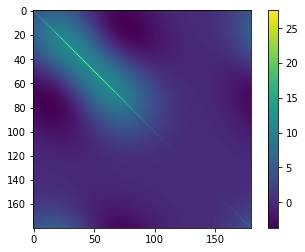

In [182]:
plt.imshow(Sigma1_E)
plt.colorbar()
plt.show()

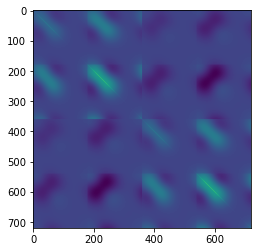

In [176]:
plt.imshow(Sigma)
plt.show()

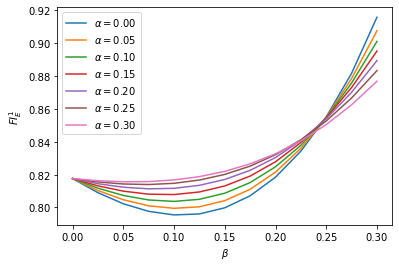

In [177]:
for i in range(len(FI_1lst)):
    plt.plot(betas, FI_1lst[i], label=r'$\alpha =$'f'{alphas[i]:.2f}')
    
plt.legend()
plt.ylabel(r'$FI_E^1$')
plt.xlabel(r'$\beta$')

plt.show()